In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import utils
import forward_model
import globals
import gradient_descent
import least_squares
import section_search
import coordinate_descent
import initialization

import torch
import scipy

cuda


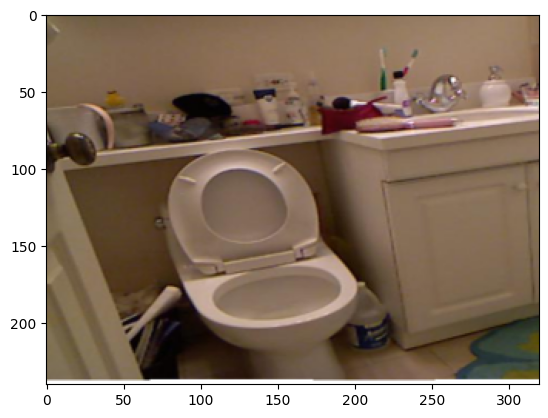

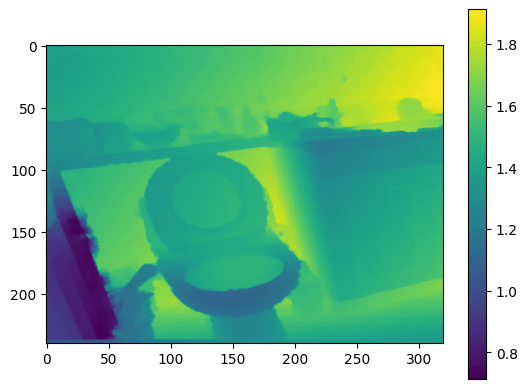

adaptive kernel size set to 11


In [2]:
globals.init_NYUv2()

# EXPERIMENT_NAME = 'coord-descent-bracket-search'
# experiment_folder = utils.create_experiment_folder(EXPERIMENT_NAME)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

IMAGE_RANGE = 255.

# load data 
# gt_aif, gt_dpt = utils.load_single_sample(sample='0045', set='train', fs=5, res='half')
gt_aif, gt_dpt, _ = utils.load_sample_image(fs=5, res='half')
gt_aif = gt_aif * IMAGE_RANGE

plt.imshow(gt_aif / IMAGE_RANGE)
plt.show()

plt.imshow(gt_dpt)
plt.colorbar()
plt.show()

width, height = gt_dpt.shape

max_kernel_size = utils.kernel_size_heuristic(width, height)
print('adaptive kernel size set to',max_kernel_size)
utils.update_max_kernel_size(max_kernel_size)

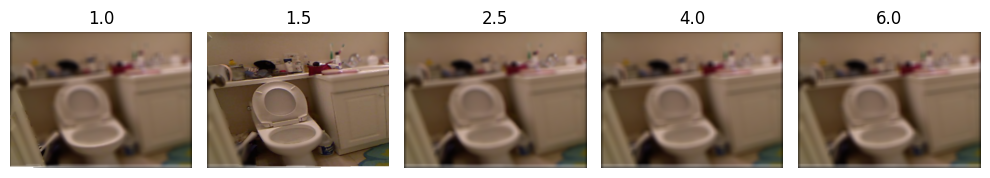

In [3]:
# forward model (torch)
FORWARD_KERNEL_TYPE = 'gaussian'
defocus_stack = forward_model.forward(gt_dpt, gt_aif, kernel=FORWARD_KERNEL_TYPE)
defocus_stack_torch = forward_model.forward_torch(gt_dpt, gt_aif, kernel=FORWARD_KERNEL_TYPE)#.float() / 255.0)
utils.plot_single_stack(defocus_stack_torch / IMAGE_RANGE, globals.Df)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.00992995..1.0000007].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.009929965..1.0000011].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.009929971..1.0000011].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.009929973..1.0000018].


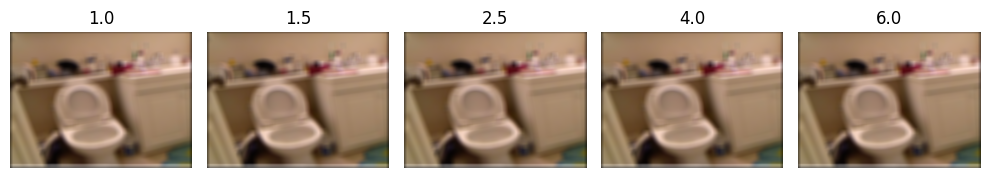

In [4]:
dpt = torch.full((width,height), 0.1).to(gt_aif.device)
defocus_stack_grid = forward_model.forward_torch(dpt, gt_aif)
utils.plot_single_stack(defocus_stack_grid / IMAGE_RANGE, globals.Df)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.1428571428571428].


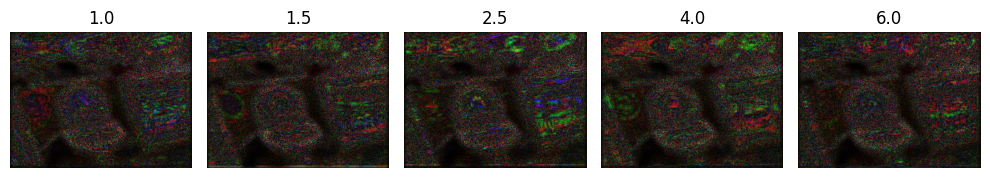

3.1839651601670324e-10


In [5]:

width, height, _ = gt_aif.shape
# indices = forward_model.precompute_indices(width, height)
u, v = forward_model.compute_u_v()


r = forward_model.computer(torch.tensor([[0.1]]), globals.Df).unsqueeze(-1).unsqueeze(-1)
# print(r)
# print(r.shape, u.shape, v.shape)
G, _ = forward_model.computeG(r, u, v)
# print(G.shape)
# print(G)
G = G.squeeze()    
defocus_stack_grid_test = np.zeros((G.shape[0], width, height, 3))
for j in range(G.shape[0]): # each focal setting
    kernel = G[j]
    for k in range(3):
        defocus_stack_grid_test[j,:,:,k] = scipy.ndimage.convolve(gt_aif[:,:,k], kernel, mode='constant')



utils.plot_single_stack(abs(defocus_stack_grid_test -defocus_stack_grid.numpy()), globals.Df)
print(np.mean((defocus_stack_grid_test -defocus_stack_grid.numpy())**2))
#     defocus_stack = forward_model.forward_torch(dpt, gt_aif, indices=indices)
#     all_losses[:,:,i] = objective_full(dpt, gt_aif, defocus_stack_torch, beta=beta, proxy=proxy, gamma=gamma, last_dpt=last_dpt)
#     # all_losses[:,:,i] = torch.mean((defocus_stack_torch - defocus_stack) ** 2, dim=[0,3]).cpu().numpy()
#     # if proxy is not None:
#     #     all_losses[:,:,i] += (beta * (dpt - proxy)**2).cpu().numpy()

# argmin_indices = np.argmin(all_losses, axis=2)
# depth_map = Z[argmin_indices]

# return depth_map, Z, argmin_indices, all_losses



In [6]:
gt_aif = torch.from_numpy(np.random.rand(width, height, 3))
defocus_stack_torch = torch.from_numpy(np.random.rand(5, width, height, 3))


depth_map2, Z2, argmin_indices2, all_losses2 = section_search.grid_search(gt_aif, defocus_stack_torch)

Grid search         : 100%|███████████████████| 100/100 [03:01<00:00,  1.82s/it]


In [8]:
depth_map, Z, argmin_indices, all_losses = section_search.grid_search_opt(gt_aif, defocus_stack_torch)


Grid search         : 100%|███████████████████| 100/100 [00:14<00:00,  6.84it/s]


In [9]:
print(np.allclose(depth_map, depth_map2, rtol=1e-5, atol=1e-8))
print(np.allclose(Z, Z2, rtol=1e-5, atol=1e-8))
print(np.allclose(argmin_indices, argmin_indices2, rtol=1e-5, atol=1e-8))
print(np.allclose(all_losses, all_losses2, rtol=1e-5, atol=1e-8))

False
True
False
True


In [13]:
print(np.max(np.abs(all_losses - all_losses2)))

8.294790179719236e-08


In [14]:
Z2_mapped_to_old_indices = Z2[argmin_indices]
print("Max diff using same indices:", np.max(np.abs(Z - Z2)))  # should still be small
print("Max diff in mapped depth_maps:", np.max(np.abs(depth_map - Z2_mapped_to_old_indices)))

Max diff using same indices: 0.0
Max diff in mapped depth_maps: 0.0
